In [1]:
import pandas as pd
import math
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import warnings
warnings.filterwarnings('ignore')

I'm using yfinance library to download my ticker stock data into a dataframe and setting auto-adjust to True so that all the returned prices are adjusted for potential corporate actions, such as splits.

In [2]:
df = yf.download('AAPL', start='2016-12-12',auto_adjust = True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2016-12-12,26.605967,27.007558,26.418088,26.608316,105497600
2016-12-13,26.735136,27.223621,26.714001,27.052183,174935200
2016-12-14,27.016956,27.289379,27.002865,27.052183,136127200
2016-12-15,27.096800,27.413847,27.061575,27.200134,186098000
2016-12-16,27.352785,27.359830,27.160210,27.235361,177404400


Plot of the ticker's closing price 

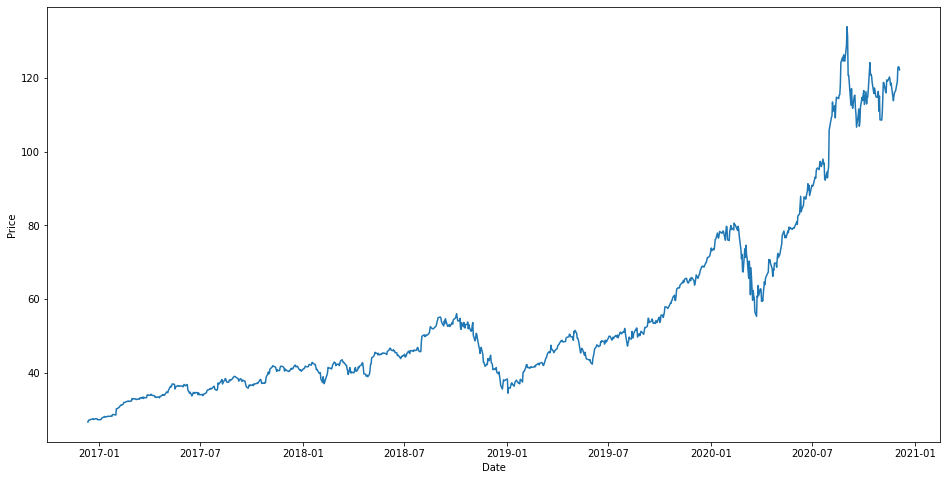

In [3]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.xlabel("Date")
plt.ylabel("Price");

In [4]:
def average_gainloss(series, window_size, average):
    a = (window_size-1) / window_size
    ak = a**np.arange(len(series)-1, -1, -1) #arange in descending order
    return np.append(average, np.cumsum(ak * series) / ak / window_size + average * a**np.arange(1, len(series)+1))


def rsi(df, window_size = 14):

    df['change'] = df['Close'].diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)
    df.loc[window_size:,'avg_gain'] = average_gainloss( df.gain[window_size+1:].values, window_size, df.loc[:window_size, 'gain'].mean())
    df.loc[window_size:,'avg_loss'] = average_gainloss( df.loss[window_size+1:].values, window_size, df.loc[:window_size, 'loss'].mean())
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))
    
    return df

In [5]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data = df.copy()
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

For the model, all we need is the ticker's closing price so I first filter the dataframe to only use the 'Close' column. I then create the dataset by converting it to a numpy array.
I then split the dataset by 80% training and 20% for testing.

In [6]:
#create a dataframe with only 'Close' column
data = df.filter(['Close', 'Volume'])
temp = df.filter(['Close'])

#have to change the index to int temporarly for the rsi method
date_index = data.index
data.index = np.arange(0,df.shape[0])

#compute RSI and keep only Close and final RSI column
data =  rsi(data, 14).filter(['Close','Volume','rsi'])

#reset index to Date format
data.index = date_index

#compute ATR and create ATR column to data
atr_values = atr(df)
data['ATR'] = atr_values

#convert to a numpy array
dataset = data.values
y_shape_dataset = temp.values

#slice the first 14 NaN values of RSI
data = data[14:]
dataset = dataset[14: , :]
y_shape_dataset = y_shape_dataset[14: , :]

#Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

data

,Close,Volume,rsi,ATR
Date,,,,
2017-01-03,27.277639,115127600,69.601072,0.411478
2017-01-04,27.247108,84472400,68.286057,0.394835
2017-01-05,27.385668,88774400,70.966998,0.384247
2017-01-06,27.690971,127007600,75.817801,0.385150
2017-01-09,27.944603,134247600,78.962455,0.383137
2017-01-10,27.972786,97848400,79.284810,0.373887
2017-01-11,28.123089,110354400,80.960380,0.369491
2017-01-12,28.005665,108344800,75.801831,0.368932
2017-01-13,27.956350,104447600,73.678592,0.356168


Next is to preprocess the data. I'm using MinMaxScaler to scale the data for values between 0 and 1.

To compute a prediction, I am using the past 60 days of data to predict the 61st. 
To do so, I create a training data set that contains the past 60 day closing price values.
So the first column in the ‘x_train’ data set will contain values from the data set from index 0 to index 59  and the second column will contain values from the data set from index 1 to index 60 and so on and so forth.
The ‘y_train’ data set will contain the 61st value located at index 60 for it’s first column and the 62nd value located at index 61 of the data set for it’s second value and so on and so forth.

In [7]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

y_scaler = MinMaxScaler(feature_range=(0, 1)) 
y_scaled = y_scaler.fit_transform(y_shape_dataset)

train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,:])
    y_train.append(train_data[i,0])

In [8]:
#Convert x_train and y_train to numpy arrays to be used in training the LSTM model.
x_train, y_train = np.array(x_train), np.array(y_train)

Now I have to reshape the data into the shape accepted by an LSTM.
That is a 3 dimensional input of the form: number of samples, number of time steps and number of features.
The number of samples is the number of rows in our training data, the number of time steps is the number of columns and number of features is just one, the closing price.

In [9]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],4))
x_train.shape

(732, 60, 4)

Next I build the model, compile it using mean squared error loss and fit it to our training data.
Build the LSTM model to have two LSTM layers with 50 neurons and two Dense layers, one with 25 neurons and the other with 1 neuron.

In [10]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True,input_shape=(x_train.shape[1],4)))
model.add(LSTM(units=50))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile and train the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
732/732 - 24s - loss: 0.0012
Epoch 2/5
732/732 - 21s - loss: 4.4544e-04
Epoch 3/5
732/732 - 20s - loss: 3.6012e-04
Epoch 4/5
732/732 - 20s - loss: 2.2971e-04
Epoch 5/5
732/732 - 20s - loss: 2.5593e-04


In [11]:
# Create the Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : ,0] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,:])
    
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],4))


In [12]:
#Getting the models predicted price values
predictions = model.predict(x_test) 

#Undo scaling
predictions = y_scaler.inverse_transform(predictions)

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

32.44566652142855

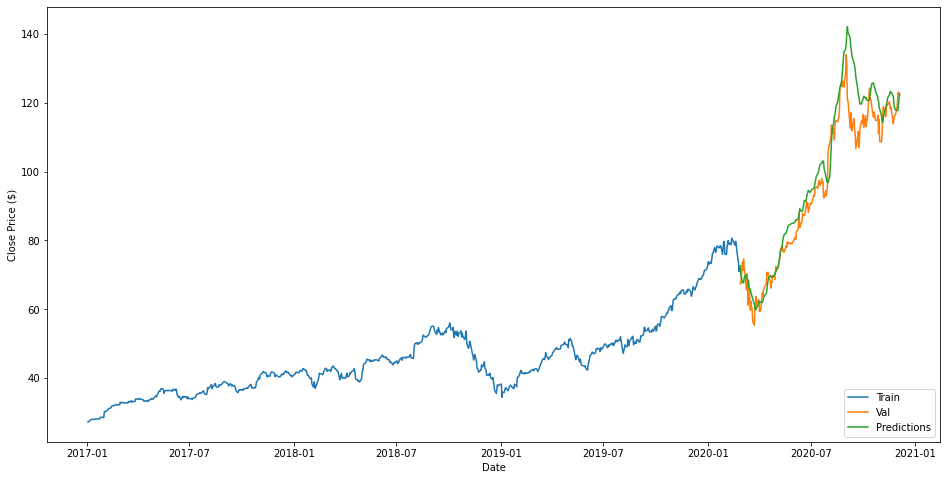

(array([ 46., 409., 295., 137.,  57.,  26.,  14.,   9.,   7.,   3.]),
 array([2.0197800e+07, 6.2972020e+07, 1.0574624e+08, 1.4852046e+08,
        1.9129468e+08, 2.3406890e+08, 2.7684312e+08, 3.1961734e+08,
        3.6239156e+08, 4.0516578e+08, 4.4794000e+08]),
 <a list of 10 Patch objects>)

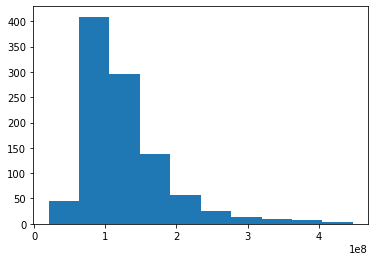

In [17]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
plt.figure()
plt.hist(df['Volume'])

In [14]:
#show actual and predicted price
valid

,Close,Volume,rsi,ATR,Predictions
Date,,,,,
2020-02-27,67.403557,320605600,28.734185,2.377070,72.642593
2020-02-28,67.364128,426884800,28.677735,2.595231,70.146530
2020-03-02,73.635773,341397200,46.636236,2.904125,67.772995
2020-03-03,71.297157,319475600,42.353724,3.017047,67.642555
2020-03-04,74.604240,219178400,49.426203,3.049382,67.709282
2020-03-05,72.184303,187572800,45.068870,3.031001,68.864151
2020-03-06,71.225685,226176800,43.435319,3.020270,69.691978
2020-03-09,65.592308,286744800,35.330949,3.262719,69.968475
2020-03-10,70.316368,285290000,44.656493,3.386463,68.910667
